In [1]:
import numpy as np
import pandas as pd

from code.AlgorithmComp_class import AlgorithmComp

In [4]:
ran_var = False
ran_int = True
n_fix = 1
a_type = 'alpha' # set 't' or 'alpha'
tol = 0.01
model = 'P'  # set 'B' or 'P'
n = 100
sim = True

AC = AlgorithmComp(ran_var, ran_int, n_fix, sim, tol, model, fix=None, lengths=None, y=None, N=None, t=None)

In [5]:
AC.N

10

In [6]:
AC.int_values

array([ 2.5,  1. , -1. ])

In [7]:
AC.y

[array([ 6.,  7., 14., 13., 15., 11., 12., 19., 13., 20., 12., 10., 15.,
        15.,  7.,  6., 22.,  8., 15., 18.,  9.,  9., 19.,  8.,  6.,  5.,
         8., 10.,  9., 15., 12., 13., 11., 23.,  7., 12.,  5., 11.,  9.,
         5.,  5., 10., 14.,  6., 15.,  9.,  9.,  8., 10.,  6., 11., 10.,
         7., 13., 24., 19., 12., 13.,  6.,  9., 11., 10., 18., 10., 15.,
        22., 10., 24.,  5., 15.,  8., 10., 15., 13.,  8., 10., 10., 21.]),
 array([14., 15., 21.,  6., 11.,  9.,  9., 18., 17., 16., 19., 15., 13.,
        17., 14., 19., 13.,  1., 12.,  8., 13., 33.,  8., 29., 20., 29.,
        14., 13., 12., 13.,  9., 13., 15., 14., 11., 10., 25.,  8., 12.,
        10.,  7., 22.,  9., 26., 21., 15., 25., 10., 15.,  8., 17., 12.,
         7.,  5.,  9., 13., 13.,  7., 17., 20., 14.,  9., 13., 11.,  6.,
         9., 11., 26.,  6., 11.,  7., 19., 15.,  9.]),
 array([ 3.,  3.,  2.,  3., 10.,  1.,  5.,  4.,  1.,  3.,  4.,  4.,  3.,
         5.,  2.,  2.,  2.,  3.,  2.,  5.,  0., 12.,  1.,  3.,  4.,

In [17]:
from cmdstanpy import cmdstan_path
cmdstan_path()

# Create folder to store .stan files
import os
if not os.path.exists("./code/stan"):
    os.mkdir("./code/stan")

# Import modules
import numpy as np
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

# Import functions
from cmdstanpy import CmdStanModel
from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [18]:
stan_model_code = """
data {
    int<lower=1> Ntot;
    int<lower=1> Ngroups;
    int<lower=1> x_size;
    int<lower=1> z_size;
    int<lower=1> M_max;
    real<lower=0> alpha; // Typically 1 / M_max

    array[Ntot] int<lower=0> y;              // Updated to new array syntax
    array[Ngroups] int<lower=1> group_sizes; // Updated to new array syntax

    matrix[Ntot, x_size] X;
    matrix[Ntot, z_size] Z;
}

parameters {
    array[M_max] vector[z_size] b; // Changed to array syntax for compatibility
    vector[x_size] regressors;
    simplex[M_max] omega;
}

transformed parameters {
    vector[Ntot] fixed_means;
    for (i in 1:Ntot) {
        fixed_means[i] = dot_product(X[i, :], regressors);
    }
}

model {
    omega ~ dirichlet(rep_vector(1, M_max) * alpha);
    b ~ multi_normal_cholesky(rep_vector(0, z_size), diag_matrix(rep_vector(1, z_size)));
    regressors ~ normal(0, 1);

    int j = 1; // Initialize j before looping over groups
    for (i in 1:Ngroups) {
        vector[M_max] log_probas = log(omega);
        for (k in 1:group_sizes[i]) {
            for (m in 1:M_max) {
                real rate = exp(fixed_means[j] + dot_product(Z[j, :], b[m]));
                log_probas[m] += poisson_lpmf(y[j] | rate);
            }
            j += 1;
        }
        target += log_sum_exp(log_probas);
    }
}

generated quantities {
    vector[Ngroups] clus_allocs;
    int j = 1;

    for (i in 1:Ngroups) {
        vector[M_max] log_probas = log(omega);
        for (k in 1:group_sizes[i]) {
            for (m in 1:M_max) {
                real rate = exp(fixed_means[j] + dot_product(Z[j, :], b[m]));
                log_probas[m] += poisson_lpmf(y[j] | rate);
            }
            j += 1;
        }
        clus_allocs[i] = categorical_rng(softmax(log_probas));
    }
}

"""

In [19]:
# Write model to file
stan_file = "./code/stan/mymodel.stan"
with open(stan_file, "w") as f:
    print(stan_model_code, file=f)

In [20]:
# Compile stan model
stan_model = CmdStanModel(stan_file=stan_file)

12:21:15 - cmdstanpy - INFO - compiling stan file /Users/alessandragni/Documents/DATA/POLITECNICO/PHD/CODE_REPO/glmmDREclust/code/stan/mymodel.stan to exe file /Users/alessandragni/Documents/DATA/POLITECNICO/PHD/CODE_REPO/glmmDREclust/code/stan/mymodel
12:21:25 - cmdstanpy - INFO - compiled model executable: /Users/alessandragni/Documents/DATA/POLITECNICO/PHD/CODE_REPO/glmmDREclust/code/stan/mymodel


In [21]:
# Flatten each key's arrays into a single column, then find the maximum length
columns = {}
max_length = 0
for key, arrays in AC.fix.items():
    # Concatenate arrays under each key into a single 1D array
    combined_array = np.concatenate(arrays)
    columns[key] = combined_array
    # Update maximum length
    max_length = max(max_length, len(combined_array))

# Pad each column to ensure equal length using np.nan for missing values
padded_columns = []
for key in sorted(columns.keys()):  # Sort keys to keep order consistent
    column = np.pad(columns[key], (0, max_length - len(columns[key])), constant_values=np.nan)
    padded_columns.append(column)

# Stack columns horizontally to form the final matrix
X = np.column_stack(padded_columns)

print(X)

[[-1.40131e+00]
 [-1.06848e+00]
 [ 6.94352e-02]
 [ 8.85995e-03]
 [ 2.94301e-01]
 [ 5.77957e-01]
 [ 1.21665e+00]
 [ 8.59783e-01]
 [ 9.01806e-02]
 [ 1.31157e+00]
 [-6.88114e-01]
 [-7.78674e-01]
 [ 4.25638e-01]
 [ 6.72859e-01]
 [-1.91835e+00]
 [-1.99953e+00]
 [-4.88404e-02]
 [-2.62244e-02]
 [-3.88533e-01]
 [ 1.15549e+00]
 [-5.59528e-02]
 [-8.43239e-01]
 [ 1.17148e+00]
 [-8.26565e-01]
 [-5.32381e-01]
 [ 1.26378e-01]
 [-1.06379e+00]
 [-4.30612e-01]
 [-7.26442e-01]
 [-4.67360e-01]
 [-1.35525e+00]
 [-4.56879e-01]
 [-1.05277e+00]
 [-9.56219e-03]
 [-1.59555e+00]
 [-1.50862e+00]
 [-9.33909e-01]
 [-6.18670e-01]
 [-2.94836e-01]
 [-1.00660e+00]
 [-2.05387e+00]
 [-4.30407e-01]
 [ 3.94723e-01]
 [-4.45558e-01]
 [ 5.55477e-01]
 [-7.37829e-01]
 [-8.34186e-02]
 [-1.40468e+00]
 [ 6.60059e-01]
 [-6.80720e-01]
 [-1.19063e+00]
 [ 1.37651e+00]
 [-1.69392e+00]
 [ 2.48417e-01]
 [ 5.26823e-02]
 [ 1.75774e+00]
 [-1.76602e+00]
 [ 2.89641e-01]
 [-4.77929e-01]
 [-1.89010e+00]
 [-2.86076e-01]
 [-1.17741e+00]
 [ 1.749

In [22]:
Z = np.ones((sum(AC.lengths), 1))

In [23]:
Ntot = sum(AC.lengths)
Ngroups = M_max = AC.N
x_size = len(AC.fix_var_values)
z_size = ran_int + ran_var
alpha = 1/M_max
y = np.array(np.concatenate(AC.y), dtype=int)
group_sizes = AC.lengths


# Prepare data list for stan
my_data = {
    "Ntot": Ntot,
    "Ngroups": Ngroups,
    "x_size": x_size,
    "z_size": z_size,
    "M_max": M_max,

    "alpha" : alpha,

    "y": y,
    "group_sizes": group_sizes,

    "X": X,
    "Z": Z
}

In [24]:
# Run the sampler
stan_fit = stan_model.sample(data=my_data, chains=4, parallel_chains=4, 
                             iter_warmup=1000, iter_sampling=5000)

# Convert chain to arviz format
cmdstanpy_data = az.from_cmdstanpy(stan_fit)

12:21:43 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [43]:
import arviz as az

# Assuming cmdstanpy_data is the InferenceData object from the previous step

# 1. Get the posterior samples from the InferenceData object
posterior_samples = cmdstanpy_data.posterior

# 2. Extract specific parameters (e.g., 'b', 'regressors', and 'omega')
b_samples = posterior_samples['b']
regressors_samples = posterior_samples['regressors']
omega_samples = posterior_samples['omega']

In [44]:
stan_fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-1592.490000,0.045133,3.52901,-1598.81000,-1592.200000,-1587.29000,6113.950,1.912550,1.00073
"b[1,1]",0.356225,0.053735,1.24721,-1.40405,0.277515,2.51870,538.717,0.168520,1.00175
"b[2,1]",0.312135,0.053475,1.23337,-1.39868,0.202263,2.51655,531.974,0.166410,1.00902
"b[3,1]",0.372424,0.065903,1.24602,-1.41708,0.317555,2.51813,357.474,0.111824,1.01855
"b[4,1]",0.288235,0.045776,1.19855,-1.42989,0.215875,2.51188,685.549,0.214451,1.00374
...,...,...,...,...,...,...,...,...,...
clus_allocs[7],5.574450,0.049447,2.83321,1.00000,6.000000,10.00000,3283.020,1.026980,1.00089
clus_allocs[8],5.479150,0.047907,2.86462,1.00000,5.000000,10.00000,3575.450,1.118460,1.00061
clus_allocs[9],5.474450,0.047906,2.85651,1.00000,5.000000,10.00000,3555.460,1.112210,1.00024
clus_allocs[10],5.472400,0.048113,2.85723,1.00000,5.000000,10.00000,3526.740,1.103220,1.00048


In [45]:
clus_allocs_summary = az.summary(stan_fit, var_names=['clus_allocs'])

# Print the summary
print(clus_allocs_summary)

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
clus_allocs[0]  5.181  3.008     1.0     10.0      0.179    0.126     282.0   
clus_allocs[1]  5.174  3.004     1.0     10.0      0.182    0.129     271.0   
clus_allocs[2]  5.586  2.828     1.0     10.0      0.050    0.035    3241.0   
clus_allocs[3]  5.576  2.829     1.0     10.0      0.050    0.036    3170.0   
clus_allocs[4]  5.585  2.829     1.0     10.0      0.050    0.035    3204.0   
clus_allocs[5]  5.576  2.826     1.0     10.0      0.051    0.036    3105.0   
clus_allocs[6]  5.574  2.833     1.0     10.0      0.049    0.035    3261.0   
clus_allocs[7]  5.479  2.865     1.0     10.0      0.048    0.034    3600.0   
clus_allocs[8]  5.474  2.857     1.0     10.0      0.048    0.034    3592.0   
clus_allocs[9]  5.472  2.857     1.0     10.0      0.048    0.034    3544.0   

                ess_tail  r_hat  
clus_allocs[0]     279.0   1.01  
clus_allocs[1]     266.0   1.01  
clus_allocs[2]    3216.0   1

/Users/alessandragni/Library/Python/3.9/lib/python/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


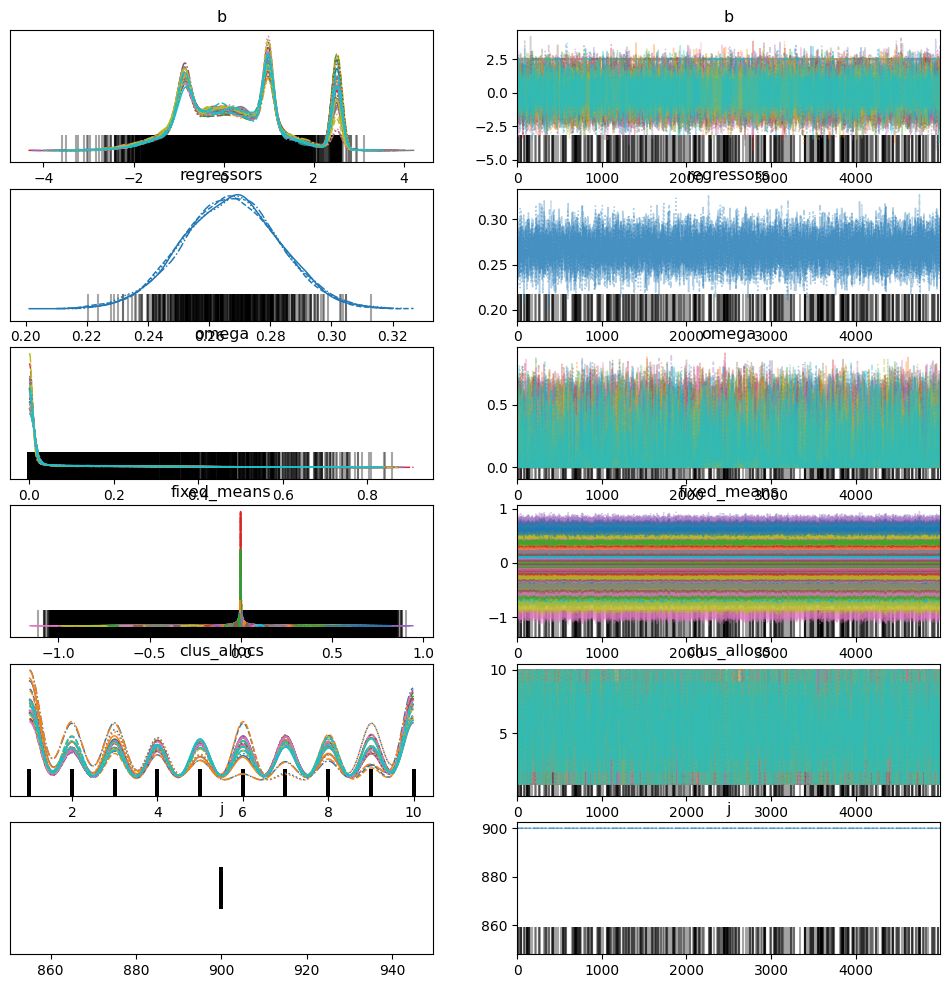

In [46]:
# Some plot using arviz
az.plot_trace(cmdstanpy_data)
plt.show()

/Users/alessandragni/Library/Python/3.9/lib/python/site-packages/arviz/plots/traceplot.py:222: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (931), generating only 20 plots
  warnings.warn(


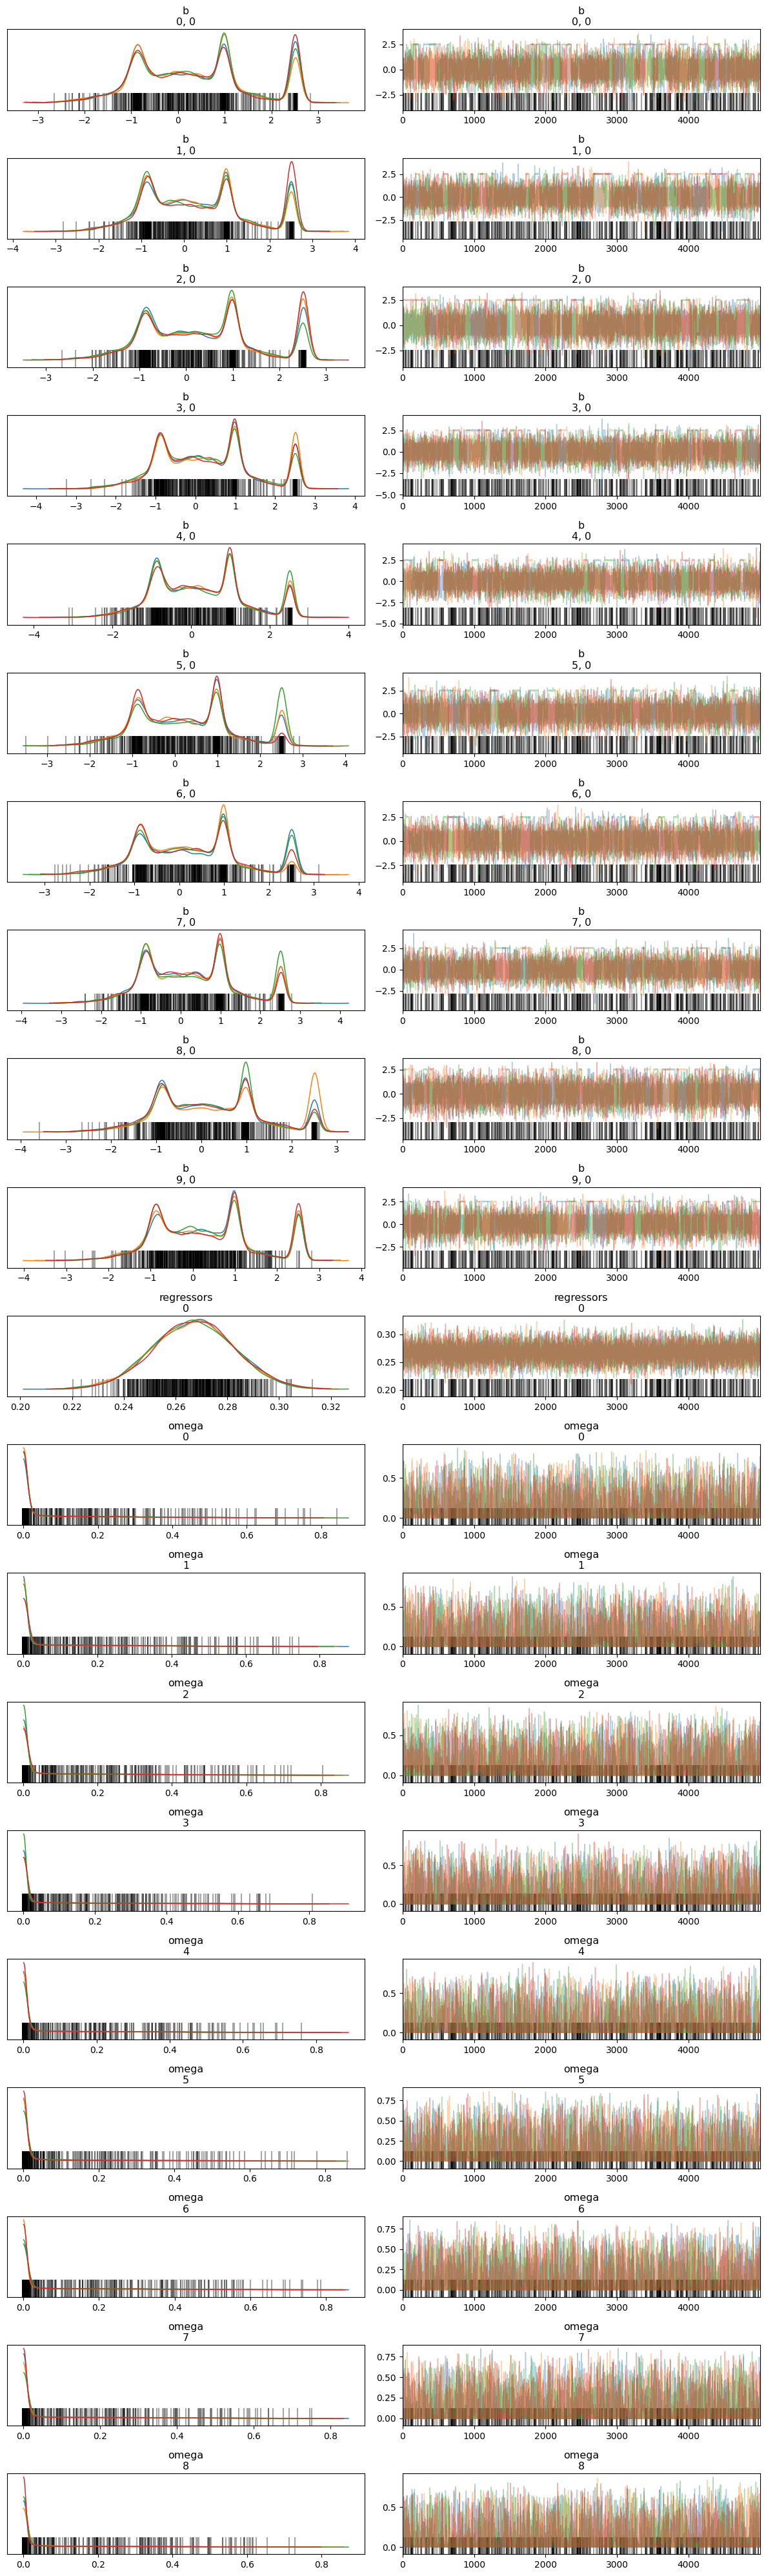

In [47]:
az.plot_trace(cmdstanpy_data, compact=False)
plt.tight_layout()
plt.show()

In [18]:
import numpy as np

# Define dimensions
Ntot = 100  # Total number of data points
x_size = 5  # Number of predictors (columns in X)
z_size = 3  # Size of the latent variable space (for Z)
M_max = 10  # Number of mixture components (for omega)
alpha = 1 / M_max  # Hyperparameter for Dirichlet distribution (for omega)

# Generate X matrix (Ntot x x_size)
# You can change the distribution or parameters based on your model assumptions
X = np.random.normal(loc=0, scale=1, size=(Ntot, x_size))  # Standard normal for predictors

# Check the shape
print(X.shape)  # Should print (Ntot, x_size)

# Generate other data for the model (example values for illustration)
y = np.random.poisson(lam=5, size=Ntot)  # Poisson counts for the response variable
group_sizes = np.random.randint(1, 10, size=10)  # Random group sizes (sum must be Ntot)
Z = np.random.normal(loc=0, scale=1, size=(Ntot, z_size))  # Random Z matrix (Ntot x z_size)

# Packaging everything into a dictionary for Stan
data = {
    'Ntot': Ntot,
    'Ngroups': len(group_sizes),
    'x_size': x_size,
    'z_size': z_size,
    'M_max': M_max,
    'alpha': alpha,
    'y': y,
    'group_sizes': group_sizes,
    'X': X,
    'Z': Z
}

# Now you can pass the 'data' dictionary to the Stan model


(100, 5)
